<a href="https://colab.research.google.com/github/ieju4n/test/blob/master/projeto_final_DL_resultados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Repo Deep Learning

This repository is the implementation of a project, from the Deep Learning course taught by professor Filipe Cordeiro.

## Purpose
To build a classifier using the concepts learned in Deep Learnig to solve the classification problem from sensor arrays of artificial nose


In [0]:
!git clone https://github.com/IsmaelCesar/RepositorioDeepLearning.git

Cloning into 'RepositorioDeepLearning'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 305 (delta 105), reused 254 (delta 57), pack-reused 0
Receiving objects: 100% (305/305), 171.39 MiB | 33.05 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Checking out files: 100% (91/91), done.


In [0]:
import os
import numpy as np
import logging
import pickle as pkl
import keras
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten,Dropout,Add
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers.merge import concatenate

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt

global data_folder,data_sets,ds_wine,extension
global dataset_name,sub_dataset_name,experiments_folder

data_folder = "RepositorioDeepLearning/data/"
experiments_folder = "RepositorioDeepLearning/implementations/results/"
dataset_name=""
sub_dataset_name=""

Using TensorFlow backend.


### Data Loading resources

In [0]:


extension = ".pkl"
data_sets   = {
    "fonollosa":{0:"B1-system",
                 1:"B2-system",
                 2:"B3-system",
                 3:"B4-system",
                 4:"B5-system",
                 "n_classes":4
                 },
    "turbulent_gas_mixtures":{0:"preloaded_dataset","n_classes":4},
    "windtunel":{
                0:"preloaded_dataset-L1",
                1:"preloaded_dataset-L2",
                2:"preloaded_dataset-L3",
                3:"preloaded_dataset-L4",
                4:"preloaded_dataset-L5",
                5:"preloaded_dataset-L6",
                "n_classes":11
    },
}
ds_wine = {"QWines-CsystemTR":3,
            "QWinesEa-CsystemTR":4}

def load(ds_choice,ds_idx=0):
    """
    choices : 0 -> fonollosa, 1 -> turbulent_gas_mixtures, 2 -> windtunel
    :param ds_choice: the index naming the dataset chosen
    :param ds_idx: the index if the folder containing the dataset has one or more datasets
    :return: the dataset read,the labels and  the number of classes
    """
    global data_folder, data_sets,extension,dataset_name,sub_dataset_name
    assert ds_choice < 3
    ds_name =list(data_sets.keys())[ds_choice]
    dataset_name = ds_name+"/"

    logging.info(ds_name +" Is being loaded")

    n_classes  = data_sets[ds_name]['n_classes']

    subds_name  = data_sets[ds_name][ds_idx]
    sub_dataset_name = subds_name + "/"

    data ,labels = None,None
    with open(data_folder+ds_name+"/"+subds_name+extension,'rb') as d:
        data,labels,_ = pkl.load(d)

    return data,labels,n_classes,dataset_name,sub_dataset_name

def load_wine(ds_choice):
    """
    choices : 0 -> QWines-CsystemTR, 1 -> QWinesEa-CsystemTR
    :param ds_choice: the index naming the dataset chosen
    :param ds_idx: the index if the folder containing the dataset has one or more datasets
    :return: the dataset read,the labels and  the number of classes
    """
    global data_folder, ds_wine, extension

    assert ds_choice < 2
    ds_name = list(ds_wine.keys())[ds_choice]
    dataset_name = ds_name+'/'

    logging.info(ds_name + " Is being loaded")

    n_classes = ds_wine[ds_name]

    data,labels = None,None
    with open(data_folder+"wines/"+ds_name+extension,"rb") as d:
        data,labels,_,_ = pkl.load(d)

    return data,labels,n_classes,dataset_name,sub_dataset_name



In [0]:
def data_set_reshaped(data_set):
    newData = []
    for d in data_set:
        newData.append(d.reshape(d.shape[0], d.shape[1],1).tolist())
    return np.array(newData)

def load_and_split(ds_choice,ds_idx=0,read_wine_datasets=False):
    # Loading dataset
    global input_shape,n_classes,dataset_name,sub_dataset_name
    data = None
    labels = None
    if not read_wine_datasets:
        data, labels, n_classes,dataset_name,sub_dataset_name = load(ds_choice,ds_idx)
    else:
        data, labels, n_classes, dataset_name, sub_dataset_name = load_wine(ds_choice)

    train_data, test_data,train_labels, test_labels = train_test_split(data,labels,test_size=.2)
    train_data = data_set_reshaped(train_data)
    test_data  = data_set_reshaped(test_data)

    input_shape = train_data[0].shape

    train_data,train_labels =   sklearn.utils.shuffle(train_data,train_labels)
    test_data, test_labels = sklearn.utils.shuffle(test_data, test_labels)


    return train_data,train_labels,test_data,test_labels

In [0]:
def standardize_data(train_data,test_data):
    global input_shape
    flat_train_data = train_data.reshape(train_data.shape[0], input_shape[0] * input_shape[1])
    flat_test_data = test_data.reshape(test_data.shape[0], input_shape[0] * input_shape[1])
    
    scaler = sklearn.preprocessing.StandardScaler().fit(flat_train_data)
    flat_train_data = scaler.transform(flat_train_data)
    
    scaler = sklearn.preprocessing.StandardScaler().fit(flat_test_data)
    flat_test_data = scaler.transform(flat_test_data)
    
    new_train = flat_train_data.reshape(train_data.shape[0],input_shape[0],input_shape[1],1)
    new_test = flat_test_data.reshape(test_data.shape[0], input_shape[0], input_shape[1], 1)
    return new_train,new_test

In [0]:
def split_datasamples_by_sensors(data):
    shape = data.shape
    new_split = []
    #Iterate over data columns
    for i in range(shape[2]):
        new_split.append(data[:,:,i])
        new_split[i] = new_split[i].reshape(new_split[i].shape[0],new_split[i].shape[1])
    return new_split

### Models Implementation

In [0]:
def sniffnet(input_shape,n_classes):
  kernel  = (20,input_shape[1] // 2-1)
  multiplier = 10
  out_channels = 5*multiplier
  #convolutional components
  model = Sequential()
  model.add(Conv2D(out_channels,kernel,input_shape=input_shape,use_bias=True,
                   activation='relu',name='first_conv'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Conv2D(out_channels,kernel,use_bias=True,
                   activation='relu',name='second_conv'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(AveragePooling2D())
  model.add(Flatten())
  model.add(Dense(out_channels,use_bias=True,activation='relu',name="camada_fc1"))
  model.add(BatchNormalization())
  model.add(Dense(n_classes,use_bias=True,activation='softmax',name="classificaiton"))
  
  return model
        
  

In [0]:
def sniffresnet(input_shape,n_classes):

    multiplier = 4
    kernel = (9,input_shape[1] // 2 - 1)
    out_channels = 5 * multiplier
    # First Part of the convolution
    X_input = Input(input_shape)
    X_skip  = Conv2D(out_channels,kernel,activation='relu',name='first_conv1')(X_input)
    X       = Conv2D(out_channels,kernel,padding='same',activation='relu',name='first_conv2')(X_skip)
    X       = BatchNormalization()(X)
    X       = Add()([X,X_skip])
    X       = MaxPooling2D((10,1),name="max_pool1")(X)
    
    # Second Part of the convolution
    out_channels = out_channels * multiplier
    X_skip = Conv2D(out_channels,kernel,activation='relu',name='second_conv1')(X)
    X       = Conv2D(out_channels,kernel,padding='same',use_bias=True,activation='relu',name='second_conv2')(X_skip)
    X       = BatchNormalization()(X)
    X       = Add()([X,X_skip])
    X       = MaxPooling2D((10,1),name="max_pool2")(X)  
    

    # Fully Connected Part
    X       = Flatten()(X)
    X       = Dense(100,use_bias=True,activation="relu",name="fc1")(X)
    X       = Dropout(.25)(X)
    X       = Dense(n_classes,use_bias=True,activation="softmax",name="class")(X)

    model = Model(inputs=X_input,outputs=X,name="SniffResnet")

    return model

In [0]:
def sniffmultinose(input_shape,n_classes):
    inputs_list = []
    multinose_out = []
    for i in range(input_shape[1]):

        X_input = Input((input_shape[0],),name=("input_nose_"+str(i)))
        inputs_list.append(X_input)
        X = Dense(input_shape[0],input_shape=(input_shape[0],),
                  use_bias=True,activation='relu',name=("fc1_nose_" + str(i)))(X_input)
        X = Dense(input_shape[0] // 4, use_bias=True, activation='tanh',name=("fc2_nose_"+str(i)) )(X)
        X = Dense(input_shape[0] // 8, use_bias=True, activation='tanh', name=("fc3_nose_" + str(i)))(X)
        multinose_out.append(X)

    concat = concatenate(multinose_out)

    X = Dense(100,activation='tanh',use_bias=True)(concat)
    X = Dense(100,activation='relu',use_bias=True)(X)
    X_out = Dense(n_classes,activation='softmax',name="class")(X)

    model  = Model(inputs=inputs_list,outputs=X_out,name="SniffNetMultiNose")
    return model

### Create and train  models

#### Evaluatin Models

In [0]:
def evaluate_model(test_data,test_labels,batch_size,model,H):
    ## Evaluating model
    print("[INFO] Evaluating Network")
    super_exp_folder = experiments_folder + dataset_name
    sub_exp_folder = experiments_folder + dataset_name + sub_dataset_name

    if not os.path.exists(super_exp_folder):
        os.mkdir(super_exp_folder)

    if not os.path.exists(sub_exp_folder):
        os.mkdir(sub_exp_folder)

    with open(sub_exp_folder + "eval.txt", 'w+') as f:
        predictions = model.predict(test_data, batch_size=batch_size)
        value = classification_report(test_labels.argmax(axis=1),
                                      predictions.argmax(axis=1))
        #target_names=[str(x) for x in range(n_classes)]
        print(value)
        f.write(value)
        f.close()

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, 20), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, 20), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig(sub_exp_folder + "LossAccComparison.png")
    plt.show()

#### Sniff ConvNets

[INFO] Training Network
Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 5ms/step - loss: 0.4582 - acc: 0.8500 - val_loss: 0.0486 - val_acc: 0.9833
Epoch 2/20
240/240 [==============================] - 0s 1ms/step - loss: 0.3498 - acc: 0.9250 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 3/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2613 - acc: 0.9375 - val_loss: 0.1239 - val_acc: 0.9667
Epoch 4/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1138 - acc: 0.9625 - val_loss: 0.0700 - val_acc: 0.9667
Epoch 5/20
240/240 [==============================] - 0s 1ms/step - loss: 0.0824 - acc: 0.9792 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 6/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1010 - acc: 0.9792 - val_loss: 0.0781 - val_acc: 0.9667
Epoch 7/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1269 - acc: 0.9625 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 8

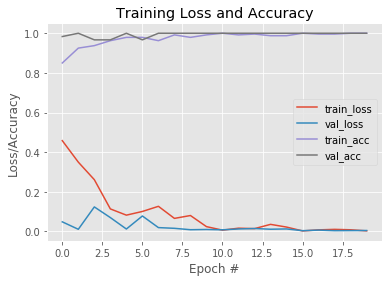

In [0]:
#Conv nets
global input_shape,n_classes
train_data,train_labels,test_data,test_labels = load_and_split(1,
                                                              read_wine_datasets=True)

train_data,test_data = standardize_data(train_data,test_data)

batch_size  = 10
epochs = 20
lr = .001

#model = sniffnet(input_shape,n_classes)
model = sniffresnet(input_shape,n_classes)
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=lr,momentum=.9),
             metrics=['accuracy'])

train_labels  = keras.utils.to_categorical(train_labels,n_classes)
test_labels = keras.utils.to_categorical(test_labels, n_classes)

print("[INFO] Training Network")
H = model.fit(train_data,train_labels,batch_size=batch_size,
         epochs=epochs,verbose=1,validation_data=(test_data,test_labels))

evaluate_model(test_data,test_labels,batch_size,model,H)


#### Funsion SniffNet

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 2s 7ms/step - loss: 0.6854 - acc: 0.7625 - val_loss: 0.2617 - val_acc: 0.9333
Epoch 2/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2337 - acc: 0.9417 - val_loss: 0.1631 - val_acc: 0.9667
Epoch 3/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1415 - acc: 0.9667 - val_loss: 0.1168 - val_acc: 0.9833
Epoch 4/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1058 - acc: 0.9833 - val_loss: 0.0971 - val_acc: 0.9833
Epoch 5/20
240/240 [==============================] - 0s 1ms/step - loss: 0.0858 - acc: 0.9875 - val_loss: 0.0751 - val_acc: 0.9833
Epoch 6/20
240/240 [==============================] - 0s 1ms/step - loss: 0.0719 - acc: 0.9875 - val_loss: 0.0661 - val_acc: 1.0000
Epoch 7/20
240/240 [==============================] - 0s 1ms/step - loss: 0.0624 - acc: 0.9875 - val_loss: 0.0592 - val_acc: 1.0000
Epoch 8/20
240/240 [===========

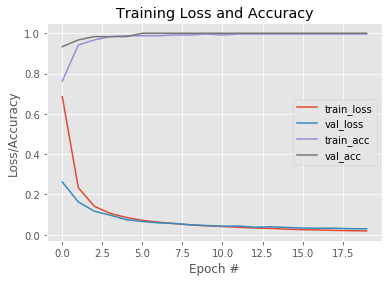

In [0]:
#Fusion SniffNet
global n_classes, input_shape
train_data, train_labels, test_data, test_labels = load_and_split(1,
                                                                  read_wine_datasets=True)
                                                                 

# normalizing data
train_data, test_data = standardize_data(train_data, test_data)

train_data = split_datasamples_by_sensors(train_data)
test_data = split_datasamples_by_sensors(test_data)

batch_size = 10
epochs = 20
lr = .001

train_labels = keras.utils.to_categorical(train_labels, n_classes)
test_labels = keras.utils.to_categorical(test_labels, n_classes)
# defining model
model = sniffmultinose(input_shape, n_classes)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=lr, momentum=.9),
              metrics=['accuracy'])


H = model.fit(train_data, train_labels, batch_size=batch_size,
              epochs=epochs, verbose=1, validation_data=(test_data, test_labels))

evaluate_model(test_data, test_labels, batch_size, model, H)